In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import os
import time
from functions import point_matching, normalize_keypoints, SuperPointWithAffNetScaleNetKornia
from kornia_moons.viz import visualize_LAF, draw_LAF_matches
import kornia as K
import kornia.feature as KF
from kornia_moons.feature import *
import pystereoglue

In [2]:
# Parameters
device = torch.device('cpu')

# Load the feature extractor
detector = SuperPointWithAffNetScaleNetKornia(init_scale = 20, upright = False).to(device)

# Load the image matching model
matcher = KF.LightGlue('superpoint', width_confidence=-1, depth_confidence=-1).eval().to(device)

# StereoGlue parameters
pool_size = 3
inlier_threshold = 5
core_number = 8

/local/home/dbarath/anaconda3/envs/main/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/local/home/dbarath/anaconda3/envs/main/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded LightGlue model


In [3]:
# The camera intrinsics
K1 = np.array([[1.23880078e+03, 0.00000000e+00, 3.90000000e+02],
 [0.00000000e+00, 1.23880078e+03, 5.31500000e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
K2 = np.array([[1.15996667e+03, 0.00000000e+00, 5.15000000e+02],
 [0.00000000e+00, 1.15996667e+03, 3.43500000e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [4]:
def load_image(fn):
    img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    return K.image_to_tensor(img, False).float() / 255.

In [5]:
img1 = load_image("02928139_3448003521.jpg")
img2 = load_image('02085496_6952371977.jpg')

img1 = img1.squeeze(0).to(device)
img2 = img2.squeeze(0).to(device)

image_size1 = img1.shape
image_size2 = img2.shape

In [6]:
start_time = time.time()
lafs1, r1, desc_1_sp, desc_1_hn = detector(img1)
end_time = time.time()
print(f"{lafs1.shape[1]} keypoints are found in {end_time - start_time:.2f} seconds")

start_time = time.time()
lafs2, r2, desc_2_sp, desc_2_hn = detector(img2)
end_time = time.time()
print(f"{lafs1.shape[1]} keypoints are found in {end_time - start_time:.2f} seconds")

2048 keypoints are found in 2.83 seconds
2048 keypoints are found in 2.56 seconds


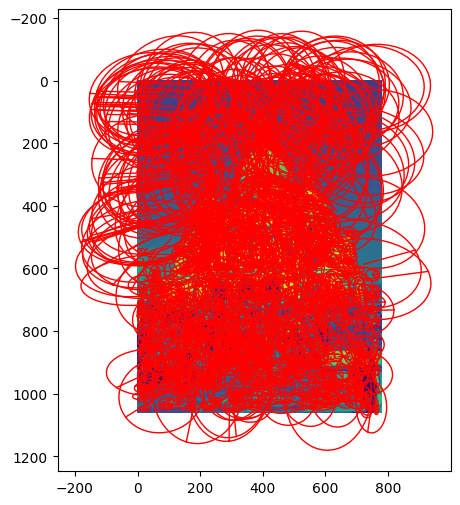

In [7]:
fig = visualize_LAF(img1, torch.tensor(lafs1), figsize=(8,6))     

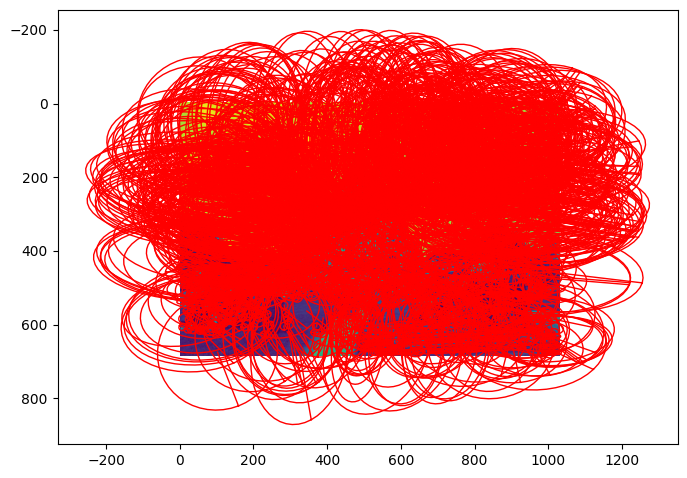

In [8]:
fig = visualize_LAF(img2, torch.tensor(lafs2), figsize=(8,6))     

In [9]:
# Select the last column of the LAFs (1 * n * 2 * 3) and make a matrix of 2D points
kps1 = lafs1[0, :, :2, 2].reshape(1, -1, 2)
kps2 = lafs2[0, :, :2, 2].reshape(1, -1, 2)

desc_1_sp = desc_1_sp.reshape(1, -1, 256)
desc_2_sp = desc_2_sp.reshape(1, -1, 256)

r1 = r1.reshape(1, -1)
r2 = r2.reshape(1, -1)

image_size_1 = torch.tensor([img1.shape[2], img1.shape[1]], dtype=torch.int32, device=device)
image_size_2 = torch.tensor([img2.shape[2], img2.shape[1]], dtype=torch.int32, device=device)
image_size_1 = image_size_1.reshape(1, 2)
image_size_2 = image_size_2.reshape(1, 2)

feats1 = { "keypoints": torch.from_numpy(kps1).to(device), "descriptors": torch.from_numpy(desc_1_sp).to(device), 'image_size': image_size_1 }
feats2 = { "keypoints": torch.from_numpy(kps2).to(device), "descriptors": torch.from_numpy(desc_2_sp).to(device), 'image_size': image_size_2 }

# Detect keypoints by LightGlue
start_time = time.time()
matches, scores = point_matching(feats1, feats2, matcher)
end_time = time.time()
    
# Reshape the LAFs from 1 * n * 2 * 3 to n * 6
matches = matches[:, : pool_size]
scores = scores[:, : pool_size]

# Reshape the LAFs from 1 * n * 2 * 3 to n * 6
reshaped_lafs1 = lafs1.reshape(-1, 6)
reshaped_lafs2 = lafs2.reshape(-1, 6)

# Remove rows from the matches where the first value is -1
mask = matches[:, 0] != -1
matches = matches[mask, :]
scores = scores[mask]
reshaped_lafs1 = reshaped_lafs1[mask, :]

# Swap the columns of the LAFs so that the coordinates comes first
reshaped_lafs1 = reshaped_lafs1[:, [2, 5, 0, 1, 3, 4]]
reshaped_lafs2 = reshaped_lafs2[:, [2, 5, 0, 1, 3, 4]]

print(f"{matches.shape[0]} matches are found in {end_time - start_time:.2f} seconds")

254 matches are found in 1.18 seconds


In [10]:
# Set up the configuration
config = pystereoglue.RANSACSettings()
config.inlier_threshold = inlier_threshold
config.core_number = core_number
config.scoring = pystereoglue.ScoringType.MAGSAC
config.local_optimization = pystereoglue.LocalOptimizationType.NestedRANSAC
config.final_optimization = pystereoglue.LocalOptimizationType.LSQ

In [11]:
if matches.shape[0] >= 6:
    # Run the homography estimation implemented in OpenCV
    tic = time.perf_counter()
    E_est, inliers, score, iterations = pystereoglue.estimateEssentialMatrixGravity(
        np.ascontiguousarray(reshaped_lafs1),
        np.ascontiguousarray(reshaped_lafs2),
        np.ascontiguousarray(matches), 
        np.ascontiguousarray(scores), 
        K1,
        K2,
        [image_size1[2], image_size1[1], image_size2[2], image_size2[1]],
        config = config)
    toc = time.perf_counter()
    elapsed_time = toc - tic
    
print(f"Inlier number: {len(inliers)}")
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Inlier number: 254
Elapsed time: 0.03 seconds


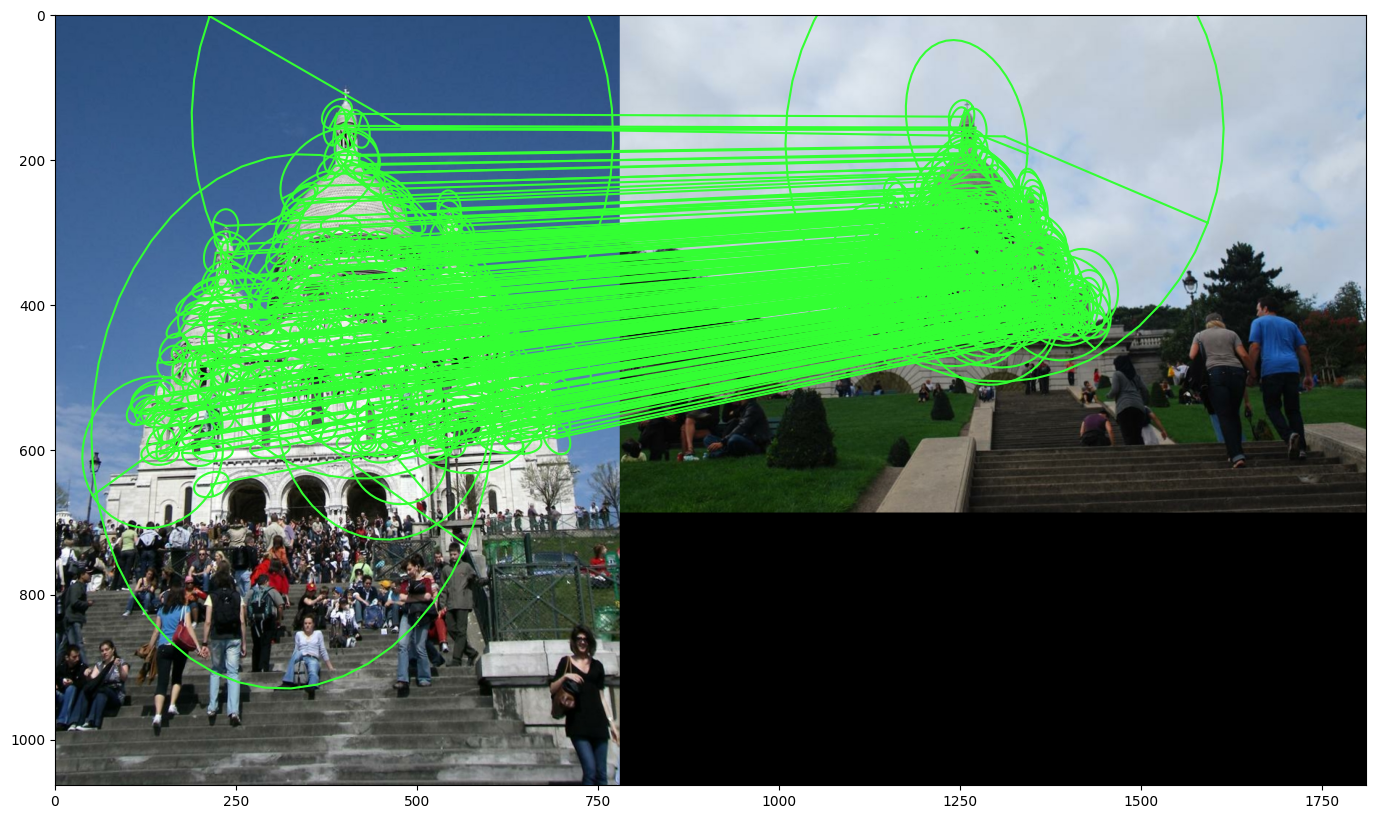

In [12]:
draw_LAF_matches(
    torch.tensor(lafs1[:, mask, :, :]),
    torch.tensor(lafs2),
    np.array(inliers),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    np.ones((len(inliers),)),
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': None, 'vertical': False})